# Clasificador Bayesiano de Idiomas

Parara reponer las 4 horas de la semana pasada, y como ejercicio de las cosas que ya vimos en clase, quiero que hagan un clasificador de idioma de 3 o 4 lenguas distintas. La característica que utilizará el clasificador, será n-gramas (caracteres) y ustedes deben determinar una n óptima basados en las métricas de evaluación dadas anteriormente. El clasificador, hagan un clasificador tipo Bayesiano (programenlo ustedes, por favor). Utilicen el truco de los exponentes que vimos la penúltima vez.

## Conceptos básicos
Probabilidad que una palabra $w$ esté en un documento de la clase $C$

$$ p(w_i \mid C) $$

Probabilidad de que un documento $D$, contenga todas las palabras $w_i$, dada una clase $C$

$$ p(D\mid C)=\prod_i p(w_i \mid C) $$

Naive Bayes Multinomial (NB)

$$ 
\begin{align}

c_{NB} & = \underset{c \in C}{\mathrm{argmax}} \ p(c_i)\prod_i p(w_i \mid c_i)^{x_i} \\

c_{NB} & = \underset{c \in C}{\mathrm{argmax}} \ \log p(c_i) + \sum_i x_i\log p(w_i \mid c_i) \\
                       & = b + \mathbf{w}_k^\top \mathbf{x} \\
\end{align}
$$

donde $b = \log p(C_k)$ y $w_{ki} = \log p_{ki}$.

Laplace Smoothing

$$ \hat{p}(w \mid c) = \frac{\mathrm{count}(w, c) + 1}{\mathrm{count}(c) + \vert V \vert} $$

Fuente: https://en.wikipedia.org/wiki/Naive_Bayes_classifier

## Entrenamiento

In [1]:
# import nltk
# p(C \vert F_1,\dots,F_n) = \frac{p(C) \ p(F_1,\dots,F_n\vert C)}{p(F_1,\dots,F_n)}
import numpy as np 
from collections import Counter
import matplotlib.pyplot as plt

Defino constantes

- n: Para definir n en n-gramas
- CLASES: Las etiquetas de clase (idiomas) a clasificar
- colores: Colores para gráficas

In [2]:
n = 2 # Agrupar los documentos en n caractéres
CLASES = ['es', 'pt', 'en']
colores = {
    'es': 'r',
    'pt': 'g',
    'en': 'b'
}

Leo cada línea de cada documento del corpus

In [3]:
corpus = {
    lang : open(f'corpus/{lang}.txt', 'r', encoding='utf-8').readlines() 
    for lang in CLASES
}

Función para obtener los n-gramas de una cadena de caracteres

In [4]:
# https://www.nltk.org/_modules/nltk/util.html#ngrams
def obtener_ngramas(text = "", n=2):
    """Función para obtener los ngramas de una cadena de caracteres
    :param str text
    :param n int
    """
    seq = iter(text)
    ngramas = []
    ngrama = ""
    while n > 1:
        # PEP 479, prevent RuntimeError from being raised when StopIteration bubbles out of generator
        try:
            next_item = next(seq)
        except StopIteration:
            # no more data, terminate the generator
            return
        ngrama += next_item
        n -= 1
    for item in seq:
        ngrama += item
        yield ngrama
        ngrama = ngrama[1:]

In [5]:
ngramas = {
    index : [ngrama for sent in corpus_lang for ngrama in (obtener_ngramas(sent, n))]
    for index, corpus_lang in corpus.items()
}
# bigramas = {
#     index : [ch1 + ch2 for sent in corpus_lang for ch1, ch2 in zip(sent[:-1], sent[1:])]
#     for index, corpus_lang in corpus.items()
# }

In [6]:
for index, ngramas_lang in ngramas.items():
    print('Lenguaje: ', index)
    print('N-gramas: ', len(ngramas_lang))
    print(ngramas_lang[:15])
    print('')

Lenguaje:  es
N-gramas:  28204
['Se', 'e ', ' t', 'to', 'om', 'ma', 'ar', 'rá', 'á ', ' c', 'co', 'om', 'mo', 'o ', ' p']

Lenguaje:  pt
N-gramas:  24788
['Se', 'er', 'rá', 'á ', ' t', 'to', 'om', 'ma', 'ad', 'do', 'o ', ' c', 'co', 'om', 'mo']

Lenguaje:  en
N-gramas:  28995
['It', 't ', ' w', 'wi', 'il', 'll', 'l ', ' b', 'be', 'e ', ' t', 'ta', 'ak', 'ke', 'en']



In [7]:
todos_ngramas = [ngrama for ngramas_lang in ngramas.values() for ngrama in ngramas_lang]
tam_corpus = len(todos_ngramas)
print(f'Tamaño corpus: {tam_corpus} n-gramas')
print(todos_ngramas[0:10])

Tamaño corpus: 81987 n-gramas
['Se', 'e ', ' t', 'to', 'om', 'ma', 'ar', 'rá', 'á ', ' c']


### Probabilidades a priori

Calculo las probabilidades a priori de las clases

In [8]:
prob_priori = {
    clase : len(ngramas_lang)/tam_corpus
    for clase, ngramas_lang in ngramas.items()
}
prob_priori

{'es': 0.3440057570102577,
 'pt': 0.30234061497554493,
 'en': 0.35365362801419736}

### Verisimilitud (Likelihood)

Ahora, calculo la probabilidad de cada n-grama dada la clase con Laplace Smoothing

Primero, cuento las ocurrencias de cada n-grama en cada clase 

In [9]:
freq_ngramas = {
    clase : Counter(ngramas_lang)
    for clase, ngramas_lang in ngramas.items()
}
for clase, counters in freq_ngramas.items():
    print(f'Idioma: {clase}')
    print(f'Número de tipos: {len(counters)}')
    print(counters.most_common(10), '\n')

Idioma: es
Número de tipos: 905
[('e ', 769), ('a ', 755), ('s ', 682), ('de', 580), (' d', 555), ('o ', 505), (' e', 500), ('en', 479), ('n ', 476), ('es', 418)] 

Idioma: pt
Número de tipos: 897
[('o ', 749), ('s ', 708), ('e ', 674), ('a ', 632), (' d', 504), (' e', 393), ('os', 370), ('de', 364), (' a', 357), ('do', 331)] 

Idioma: en
Número de tipos: 923
[('e ', 878), (' t', 680), (' a', 608), ('th', 597), ('he', 567), ('d ', 488), ('s ', 482), ('in', 460), ('er', 438), ('an', 401)] 



Ahora, la frecuencia total de los tipos en todo el corpus

In [10]:
freq_total = sum(freq_ngramas.values(), Counter())
tipos = [tipo for tipo in freq_total.keys()]
print(f'Número de tipos: {len(tipos)}')
print(tipos[:10])
# plt.figure()
# plt.title(f'Rango vs frecuencia en bigramas (TOTAL)')
# freq = [fr[1] for fr in freq_total.most_common()]
# ranks = range(1, len(freq)+1)
# plt.scatter(np.log(ranks), np.log(freq), color='#9f0ff0')
# plt.show()

Número de tipos: 1424
['Se', 'e ', ' t', 'to', 'om', 'ma', 'ar', 'rá', 'á ', ' c']


Probabilidad de ngrama $w$ en clase c

$ \hat{p}(w \mid c) = \frac{\mathrm{count}(w, c) + 1}{\mathrm{count}(c) + \vert V \vert} $

```python
likelihoods[w][c]
```

In [64]:
likelihoods = {
    tipo : {
        lang : (freq[tipo] + 1) / (len(freq) + tam_corpus)
        for lang, freq in freq_ngramas.items()
    }
    for tipo in tipos
}
ejemplos_likelihood = ['eo', 'el', 'wh', 'eu', 'th']
for ejemplo in ejemplos_likelihood:
    print(f'Probabilidad de ngrama {ejemplo}')
    print(likelihoods[ejemplo], '\n')

Probabilidad de ngrama eo
{'es': 0.0003377889301742026, 'pt': 0.0003498865884851117, 'en': 0.00020504161138584006} 

Probabilidad de ngrama el
{'es': 0.0031728031655648315, 'pt': 0.0014478065730418417, 'en': 0.001242310939573031} 

Probabilidad de ngrama wh
{'es': 1.2063890363364377e-05, 'pt': 1.206505477534868e-05, 'en': 0.0008201664455433602} 

Probabilidad de ngrama eu
{'es': 4.825556145345751e-05, 'pt': 0.0004102118623618551, 'en': 3.6183813773971774e-05} 

Probabilidad de ngrama th
{'es': 2.4127780726728754e-05, 'pt': 7.239032865209208e-05, 'en': 0.007212640212278374} 



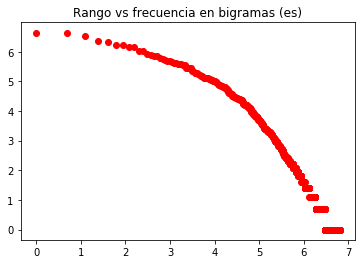

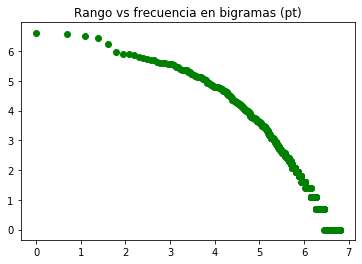

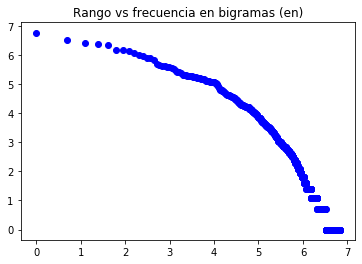

In [12]:
for clase, counters in freq_ngramas.items():
    plt.figure()
    plt.title(f'Rango vs frecuencia en bigramas ({clase})')
    freq = [fr[1] for fr in counters.most_common()]
    ranks = range(1, len(freq)+1)
    plt.scatter(np.log(ranks), np.log(freq), color=colores[clase])
    plt.show()

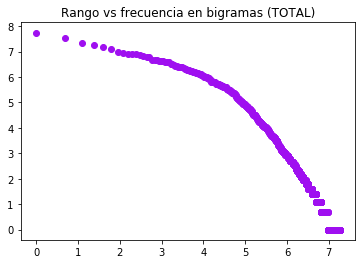

In [13]:
plt.figure()
plt.title(f'Rango vs frecuencia en bigramas (TOTAL)')
freq = [fr[1] for fr in freq_total.most_common()]
ranks = range(1, len(freq)+1)
plt.scatter(np.log(ranks), np.log(freq), color='#9f0ff0')
plt.show()

In [14]:
hapax = []
for item in reversed(freq_total.most_common()):
    if (item[1]==1):
        hapax.append(item)
    else:
        break
len(hapax)

360

In [15]:
# from itertools import count
# from collections import defaultdict
# from functools import partial

# def hashing_v1(seq):
#     mapping = defaultdict(partial(next, count()))
#     return [mapping[tuple(el)] for el in seq]

# def hashing_v2(seq):
#     mapping = defaultdict(partial(next, count()))
#     result = []
#     for le in seq:
#         le.flags.writeable = False
#         result.append(mapping[le.data])
#     return result

## Clasificación

In [88]:
test_corpus = {
    'es' : ["¿Sabías que los mosquitos suelen explotar al contacto?", "Los oídos de los camellos son 100 veces más grandes que los de una hormiga rey"],
    'pt' : ["Pensando melhor, nunca mais vou ter aquele batido de aveia.", "As perucas vermelhas dos pinguins ajudam a cobrir as suas penas"],
    'en' : ["Sometimes when I am alone in bed I think about my lightbulb", "Despite everything you did to me, I still want you to die in a terrific accident."]
}

In [89]:
test_ngramas = {
    lang : [list(obtener_ngramas(frase, n)) for frase in frases]
    for lang, frases in test_corpus.items() 
}

print(test_ngramas['es'][0])

['¿S', 'Sa', 'ab', 'bí', 'ía', 'as', 's ', ' q', 'qu', 'ue', 'e ', ' l', 'lo', 'os', 's ', ' m', 'mo', 'os', 'sq', 'qu', 'ui', 'it', 'to', 'os', 's ', ' s', 'su', 'ue', 'el', 'le', 'en', 'n ', ' e', 'ex', 'xp', 'pl', 'lo', 'ot', 'ta', 'ar', 'r ', ' a', 'al', 'l ', ' c', 'co', 'on', 'nt', 'ta', 'ac', 'ct', 'to', 'o?']


In [90]:
test_freq = {
    lang : [Counter(ngrama) for ngrama in ngramas]
    for lang, ngramas in test_ngramas.items()
}

print(test_freq['es'][0])

Counter({'s ': 3, 'os': 3, 'qu': 2, 'ue': 2, 'lo': 2, 'to': 2, 'ta': 2, '¿S': 1, 'Sa': 1, 'ab': 1, 'bí': 1, 'ía': 1, 'as': 1, ' q': 1, 'e ': 1, ' l': 1, ' m': 1, 'mo': 1, 'sq': 1, 'ui': 1, 'it': 1, ' s': 1, 'su': 1, 'el': 1, 'le': 1, 'en': 1, 'n ': 1, ' e': 1, 'ex': 1, 'xp': 1, 'pl': 1, 'ot': 1, 'ar': 1, 'r ': 1, ' a': 1, 'al': 1, 'l ': 1, ' c': 1, 'co': 1, 'on': 1, 'nt': 1, 'ac': 1, 'ct': 1, 'o?': 1})


In [91]:
test_prob = {
    lang : [
        {
            ngrama : freq/len(test_ngramas[lang][i_ejemplo])
            for ngrama, freq in freqs.items()
        }
        for i_ejemplo, freqs in enumerate(lista_freq)
    ]
    for lang, lista_freq in test_freq.items()
}

print(test_prob['es'][0])

{'¿S': 0.018867924528301886, 'Sa': 0.018867924528301886, 'ab': 0.018867924528301886, 'bí': 0.018867924528301886, 'ía': 0.018867924528301886, 'as': 0.018867924528301886, 's ': 0.05660377358490566, ' q': 0.018867924528301886, 'qu': 0.03773584905660377, 'ue': 0.03773584905660377, 'e ': 0.018867924528301886, ' l': 0.018867924528301886, 'lo': 0.03773584905660377, 'os': 0.05660377358490566, ' m': 0.018867924528301886, 'mo': 0.018867924528301886, 'sq': 0.018867924528301886, 'ui': 0.018867924528301886, 'it': 0.018867924528301886, 'to': 0.03773584905660377, ' s': 0.018867924528301886, 'su': 0.018867924528301886, 'el': 0.018867924528301886, 'le': 0.018867924528301886, 'en': 0.018867924528301886, 'n ': 0.018867924528301886, ' e': 0.018867924528301886, 'ex': 0.018867924528301886, 'xp': 0.018867924528301886, 'pl': 0.018867924528301886, 'ot': 0.018867924528301886, 'ta': 0.03773584905660377, 'ar': 0.018867924528301886, 'r ': 0.018867924528301886, ' a': 0.018867924528301886, 'al': 0.018867924528301886

Naive Bayes Multinomial (NB)

$$ 
\begin{align}

c_{NB} & = \underset{c \in C}{\mathrm{argmax}} \ p(c_i)\prod_i p(w_i \mid c_i)^{x_i} \\

c_{NB} & = \underset{c \in C}{\mathrm{argmax}} \ \log p(c_i) + \sum_i x_i\log p(w_i \mid c_i) \\
                       & = b + \mathbf{w}_k^\top \mathbf{x} \\
\end{align}
$$

donde $b = \log p(C_k)$ y $w_{ki} = \log p_{ki}$.

In [94]:
import operator
def clasificar(prueba, prob_priori, likelihood):
    return max(prob_clases(prueba, prob_priori, likelihood).items(), key=operator.itemgetter(1))

def prob_clases(prueba, prob_priori, likelihood):
    probabilidades = {
        lang : 0 for lang in prob_priori.keys()
    }
    for lang in probabilidades.keys():
        wx = 0
        for ngrama, prob in prueba.items():
            try:
                wx += np.log(likelihood[ngrama][lang])*prob
            except KeyError as err:
                print('Error: Se encontró un ngrama que no está en el vocabulario: ', err)
                return { lang : 0 for lang in prob_priori.keys() }
        probabilidades[lang] = wx + np.log(prob_priori[lang])
    return probabilidades

In [97]:
for lang, lang_list in test_prob.items():
    for id_item, test_item in enumerate(lang_list):
        print(test_corpus[lang][id_item])
        pred_prob = prob_clases(test_item, prob_priori, likelihoods)
        print('Probabilidades: ', pred_prob)
        print('Predicción: ', max(pred_prob.items(), key=operator.itemgetter(1))[0])
        print()


¿Sabías que los mosquitos suelen explotar al contacto?
Error: Se encontró un ngrama que no está en el vocabulario:  '¿S'
Probabilidades:  {'es': 0, 'pt': 0, 'en': 0}
Predicción:  es

Los oídos de los camellos son 100 veces más grandes que los de una hormiga rey
Probabilidades:  {'es': -7.383363677709825, 'pt': -7.836538480579491, 'en': -7.978664922811417}
Predicción:  es

Pensando melhor, nunca mais vou ter aquele batido de aveia.
Probabilidades:  {'es': -7.719967956796617, 'pt': -7.731738762903649, 'en': -7.9094403818101}
Predicción:  es

As perucas vermelhas dos pinguins ajudam a cobrir as suas penas
Probabilidades:  {'es': -7.524903385870794, 'pt': -7.633287202578172, 'en': -7.8336434564731885}
Predicción:  es

Sometimes when I am alone in bed I think about my lightbulb
Probabilidades:  {'es': -8.804302909962443, 'pt': -9.153734833425881, 'en': -7.66148246825256}
Predicción:  en

Despite everything you did to me, I still want you to die in a terrific accident.
Probabilidades:  {'es'